# Nicholas Tam Analysis

## Research question/interests
Research question: Given the tree dataset, how would we want to arrange the types of trees to be planted in certain locations, such that they could survive and significantly improve the ecosystmem

Given the research question, it would be ideal toanalyze relevant properties, such as the relative sizes of each location and the proportions of planted trees for each species .

In [1]:
import altair as alt
import pandas as pd
from toolz.curried import pipe
import os
from pygbif import species

# Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

In [2]:
public_trees_cleaned = pd.read_csv("../../data/processed/public_trees_cleaned.csv")
priority_order = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90']
public_trees_cleaned['HEIGHT_RANGE'] = pd.Categorical(public_trees_cleaned['HEIGHT_RANGE'], categories=priority_order, ordered=True)
public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']] = public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']].astype(str)

public_trees_cleaned.head()

,TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ON_STREET_BLOCK,ON_STREET,NEIGHBOURHOOD_NAME,STREET_SIDE_NAME,HEIGHT_RANGE_ID,HEIGHT_RANGE,DIAMETER,DATE_PLANTED,LATITUDE,LONGITUDE,NOMENCLATURE,ON_ADDRESS
0,68600,5801,COLUMBIA ST,FRAXINUS,PENNSYLVANICA,PENNSYLVANICA,GREEN ASH,5800,COLUMBIA ST,OAKRIDGE,ODD,4,40-50,14.0,NaN,49.231886,-123.110879,FRAXINUS PENNSYLVANICA,5800 COLUMBIA ST OAKRIDGE (ODD)
1,68602,5801,COLUMBIA ST,FRAXINUS,PENNSYLVANICA,PENNSYLVANICA,GREEN ASH,5800,COLUMBIA ST,OAKRIDGE,ODD,4,40-50,13.0,NaN,49.232183,-123.110868,FRAXINUS PENNSYLVANICA,5800 COLUMBIA ST OAKRIDGE (ODD)
2,68625,7520,COLUMBIA ST,ACER,RUBRUM,RUBRUM,RED MAPLE,7500,COLUMBIA ST,MARPOLE,EVEN,4,40-50,19.0,1990-03-06,49.216456,-123.112521,ACER RUBRUM,7500 COLUMBIA ST MARPOLE (EVEN)
3,68628,7580,COLUMBIA ST,ACER,RUBRUM,RUBRUM,RED MAPLE,7500,COLUMBIA ST,MARPOLE,EVEN,2,20-30,10.5,1990-03-06,49.216264,-123.112526,ACER RUBRUM,7500 COLUMBIA ST MARPOLE (EVEN)
4,68629,7580,COLUMBIA ST,ACER,RUBRUM,RUBRUM,RED MAPLE,7500,COLUMBIA ST,MARPOLE,EVEN,4,40-50,14.0,1990-03-06,49.216197,-123.112528,ACER RUBRUM,7500 COLUMBIA ST MARPOLE (EVEN)


In [3]:
display(public_trees_cleaned.describe())

,HEIGHT_RANGE_ID,DIAMETER,LATITUDE,LONGITUDE
count,181476.000000,181476.000000,181476.000000,181476.000000
mean,2.997498,12.734677,49.248839,-123.107691
std,1.939775,10.201485,0.022868,0.048920
min,1.000000,0.000000,49.200203,-123.236684
25%,1.000000,4.000000,49.230406,-123.144383
50%,2.000000,10.000000,49.248473,-123.109573
75%,4.000000,18.000000,49.266611,-123.064573
max,9.000000,305.000000,49.312730,-123.023294


### Count of each `SPECIES_NAME` that have been planted
- `Planted_Count` for each species is derived by counting the number of rows with `DATE_PLANTED` filled for each tree species.
- `Proportion_Planted` derived from dividing `Planted_Count` by the total number of the given species.
- Would ideally want a reasonably large `Total_Count` value (at least 300) to mitigate the risk of having too few samples of each species to effectively measure and compare characteristics.
- Would also want `Proportion_Planted` to be within certain range of values (between 0.33 and 0.67) to mitigate the possibility that the obtained properties of planted trees are by random chance, and ensure that there are plenty of both planted and non-planted trees to compare against each other.
- Applied log-transform to `Total_Count` to make colored value range easier to interpret.
- Greater values of `Total_Count` generally provide less extreme values of `Proportion_Planted`.

In [4]:
species_planted_count = public_trees_cleaned[public_trees_cleaned['DATE_PLANTED'].notnull()].groupby('SPECIES_NAME').size().reset_index(name='Planted_Count')
species_total_count = public_trees_cleaned.groupby('SPECIES_NAME').size().reset_index(name='Total_Count')
species_summary = species_planted_count.merge(species_total_count, on='SPECIES_NAME')
species_summary['Proportion_Planted'] = species_summary['Planted_Count'] / species_summary['Total_Count']
# species_summary[(species_summary['Total_Count'] >= 300) & (species_summary['Proportion_Planted'] >= 0.33) & (species_summary['Proportion_Planted'] <= 0.67)]

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


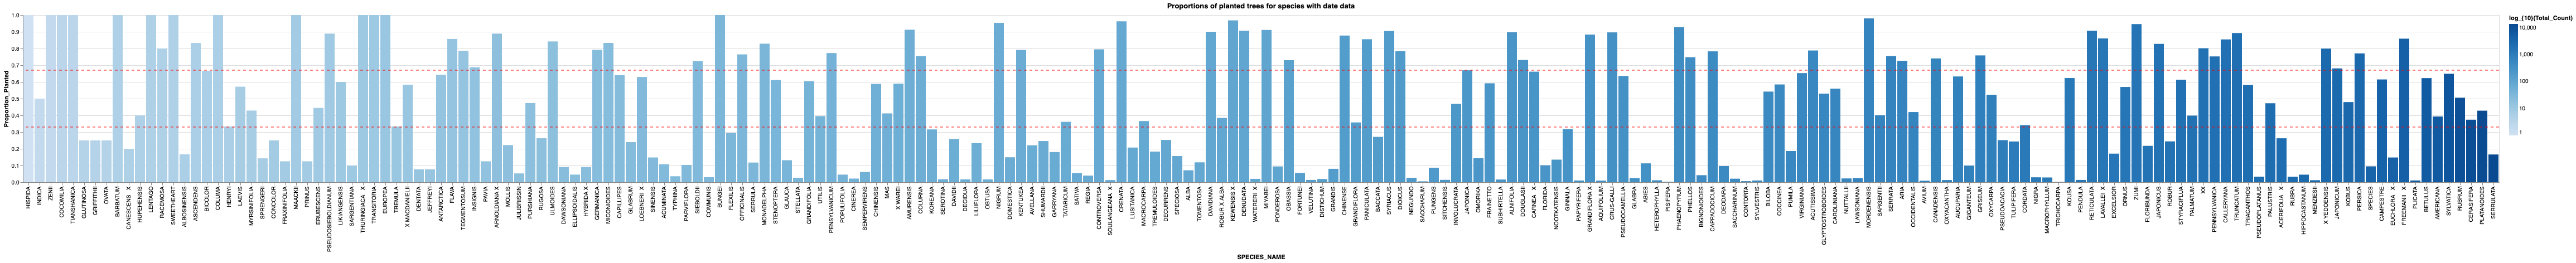

In [19]:
species_chart = alt.Chart(species_summary).mark_bar().encode(
    alt.X('SPECIES_NAME:N', sort='color'),
    alt.Y('Proportion_Planted:Q'),
    alt.Color('Total_Count', scale=alt.Scale(type='log'), title='log_{10}(Total_Count)'),
    alt.Tooltip(['Total_Count']),
).properties(
    title='Proportions of planted trees for species with date data',
).interactive()

horizontal_lines = alt.Chart(pd.DataFrame({
    'Proportion_Planted': [0.33, 0.67],
})).mark_rule(color='red', strokeDash=[5, 5]).encode(
    alt.Y('Proportion_Planted:Q'),
)

species_chart + horizontal_lines

### Scatterplot of `LATITUDE` against `LONGITUDE`
- Distribution of data points along axes of latitude and longitude.
- Provides an estimated "map" of the areas for each `NEIGHBOURHOOD_NAME` in Vancouver, and thus a better understanding of how tree density could be influenced for each area.
- Limited by the number of `NEIGHBOURHOOD_NAME` exceeding the number of colors
- Could be improved upon with `mark_geoshape()`, may require getting coordinate values that were removed in cleaning.

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/c

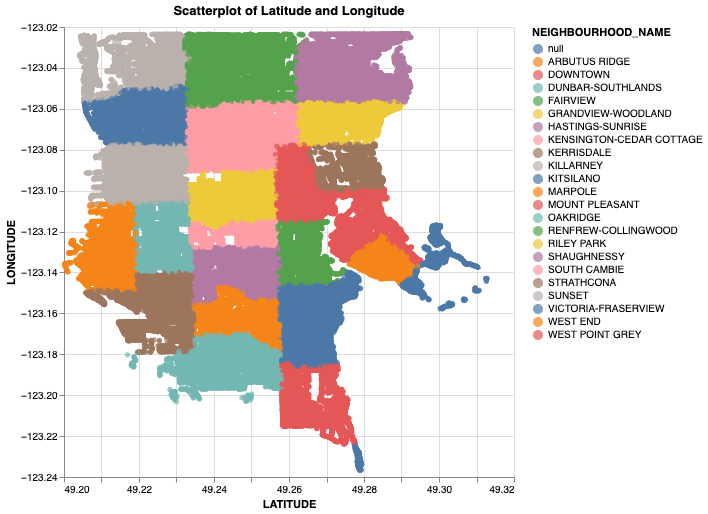

In [6]:
latvlong = alt.Chart(public_trees_cleaned).mark_circle().encode(
    alt.X('LATITUDE:Q', scale=alt.Scale(zero=False)),
    alt.Y('LONGITUDE:Q', scale=alt.Scale(zero=False)),
    alt.Color('NEIGHBOURHOOD_NAME:N'),
    alt.Tooltip(['NEIGHBOURHOOD_NAME']),
).properties(
    title='Scatterplot of Latitude and Longitude',
    width = 450, 
    height = 450
)
latvlong

### Boxplots of `DIAMETER` grouped by `HEIGHT_RANGE`
- Box plots of `DIAMETER` against `HEIGHT_RANGE`.
- For the most part, mean `DIAMETER` increases with `HEIGHT_RANGE`.
- Outliers for `DIAMETER` appear to be more frequent for lower `HEIGHT_RANGE` values, and less frequent for higher `HEIGHT_RANGE` values.

In [7]:
# public_trees_summary = public_trees_cleaned.groupby("HEIGHT_RANGE")["DIAMETER"].describe()
# upper_bound = max(public_trees_summary["75%"] + public_trees_summary["std"] * 3)
# filtered_data = public_trees_cleaned[public_trees_cleaned["DIAMETER"] <= upper_bound]

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/c

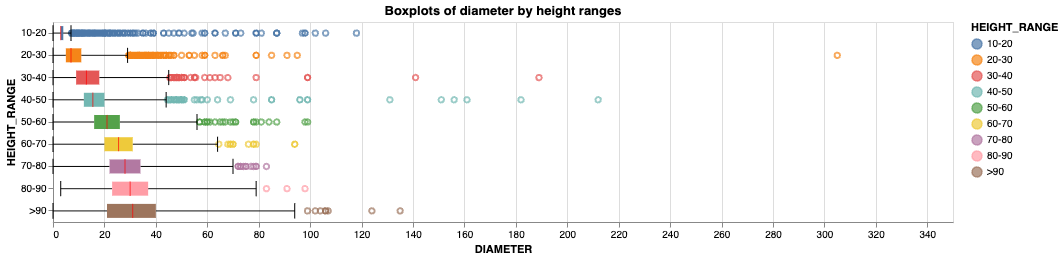

In [8]:
public_trees_box = alt.Chart(public_trees_cleaned).mark_boxplot(
    median={"color": "red"},
    extent=3,
    ticks= True,
).encode(
    # alt.X('DIAMETER:Q', scale=alt.Scale(zero=False, domain=[0, upper_bound + 10])),
    alt.X('DIAMETER:Q', scale=alt.Scale(zero=False)),
    alt.Y('HEIGHT_RANGE:N'),
    alt.Color('HEIGHT_RANGE:N'),
    # alt.Column('HEIGHT_RANGE:N'),
).properties(
    title='Boxplots of diameter by height ranges',
    width = 900, 
    height = 200
)
public_trees_box

### Number of `ON_STREET` grouped by `NEIGHBOURHOOD_NAME`
- 

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


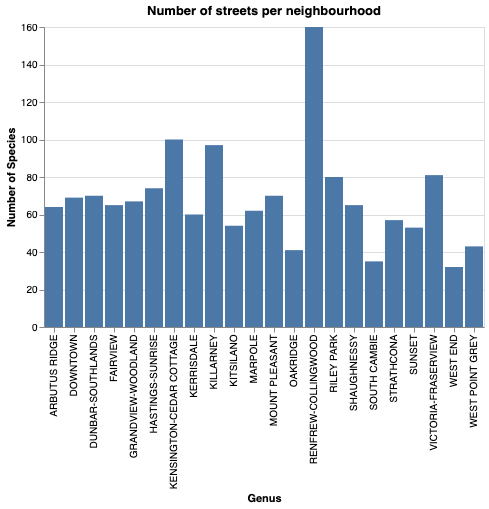

In [12]:
species_per_genus = public_trees_cleaned.groupby('NEIGHBOURHOOD_NAME')['ON_STREET'].nunique().reset_index()

species_per_genus_chart = alt.Chart(species_per_genus).mark_bar().encode(
    alt.X('NEIGHBOURHOOD_NAME:N', title='Neighbourhood'),
    alt.Y('ON_STREET:Q', title='Number of Streets'),
    alt.Tooltip(['NEIGHBOURHOOD_NAME', 'ON_STREET']),
).properties(
    title='Number of streets per neighbourhood',
)
species_per_genus_chart

### Number of dates per neighbourhood

KeyError: 'SPECIES_NAME'